<a href="https://colab.research.google.com/github/MichalRozenwald/epiCausality/blob/main/gm12878_deepCTCF_updated_extract_reads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting single read mC profiles (using the new package)

# Colab setup

If you are running in Google Colab, run the cells below. **It is expected that Colab will make you restart your runtime to enable new package versions.**

In [128]:
%%time
# Lets Colab access your Google drive
try:
    from google.colab import drive
except:
    print("""
You don't seem to be running on Google Colab so this cell is not going to be useful for you.
Make sure you are running you notebook in a conda environment set up as per README.md.
Once you have this notebook running in a correctly configured environment, proceed to the rest of the cells.
          """)
else:
    drive.mount('/content/drive')
    # Install condacolab to let us get the modkit dependency
    !pip install -q condacolab
    import condacolab
    condacolab.install()
    # Install modkit
    !conda install nanoporetech::modkit==0.2.4
    # Clone the repo, change the active path to be inside the repo, and install the package
    !rm -r dimelo
    !git clone -b modkit_parsing_beta https://github.com/streetslab/dimelo
    import os
    os.chdir('dimelo')
    !pip install ipywidgets==7.7.1 .


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
 - nanoporetech
Platform: linux-64
Solving environment: / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Cloning into 'dimelo'...
remote: Enumerating objects: 5456, done.
remote: Counting objects: 100% (1190/1190), done.
remote: Compressing objects: 100% (351/351), done.
remote: Total 5456 (delta 844), reused 1137 (delta 812), pack-reused 4266
Receiving objects: 100% (5456/5456), 206.42 MiB | 30.01 MiB/s, done.
Resolving deltas: 100% (3047/3047), done.
Processing /content/dimelo/dimelo
  Preparing metadata (setup.py) ... done
  Created wheel for dimelo: filename=dimelo-1.0.0-py3-none-any.whl size=29758 sh

After runtime restart in previous cell, run this cell to make sure your notebook is set up.

In [129]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir('/content/dimelo') # os.chdir('dimelo') #  -> change to  "os.chdir('/content/dimelo')"  or '/content/dimelo/dimelo'

except:
    pass


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
 pwd

'/content/dimelo'

In [131]:
os.chdir('/content/dimelo')  # or '/content/dimelo/dimelo'
! pwd

/content/dimelo


In [132]:
import dimelo

from dimelo import plot_enrichment_profile, load_processed, parse_bam, utils
from pathlib import Path

In [133]:
from pathlib import Path
from matplotlib import pyplot as plt
import pysam
import pandas as pd
from dimelo import plot_enrichment_profile, load_processed, parse_bam, utils

import seaborn as sns
from matplotlib.axes import Axes
import matplotlib.pyplot as plt

import numpy as np

# from . import load_processed
# from . import utils

# Getting the correct VERSION of the T2T ref genome v1.0 (NOT v1.1)  !!!
that was used to map the geep CTCF GM12878 data

In [134]:
! mkdir ./test/output/


mkdir: cannot create directory ‘./test/output/’: File exists


In [16]:
!curl https://s3-us-west-2.amazonaws.com/human-pangenomics/T2T/CHM13/assemblies/chm13.draft_v1.0.fasta.gz -o ./test/output/chm13.draft_v1.0.fasta.gz
!gunzip ./test/output/chm13.draft_v1.0.fasta.gz

curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  848M  100  848M    0     0  36.7M      0  0:00:23  0:00:23 --:--:-- 41.1M


In [17]:
ref_genome_v1_0_gm_path = Path('./test/output/chm13.draft_v1.0.fasta')

In [18]:
t2t_v1_0_cd55_30bp = "chr1:206586331-206586361" # "chr1:206586332-206586360""chr1:206586332-206586360"
t2t_v1_0_cd55_30bp

'chr1:206586331-206586361'

In [22]:
206586331-206586361

-30

CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC


([<matplotlib.axis.XTick at 0x7bc06ea8e200>,
 [Text(0, 0, 'C'),
  Text(1, 0, 'C'),
  Text(2, 0, 'G'),
  Text(3, 0, 'C'),
  Text(4, 0, 'C'),
  Text(5, 0, 'C'),
  Text(6, 0, 'C'),
  Text(7, 0, 'G'),
  Text(8, 0, 'A'),
  Text(9, 0, 'G'),
  Text(10, 0, 'G'),
  Text(11, 0, 'C'),
  Text(12, 0, 'G'),
  Text(13, 0, 'C'),
  Text(14, 0, 'G'),
  Text(15, 0, 'C'),
  Text(16, 0, 'G'),
  Text(17, 0, 'C'),
  Text(18, 0, 'G'),
  Text(19, 0, 'C'),
  Text(20, 0, 'G'),
  Text(21, 0, 'C'),
  Text(22, 0, 'G'),
  Text(23, 0, 'C'),
  Text(24, 0, 'G'),
  Text(25, 0, 'C'),
  Text(26, 0, 'G'),
  Text(27, 0, 'C'),
  Text(28, 0, 'A'),
  Text(29, 0, 'C')])

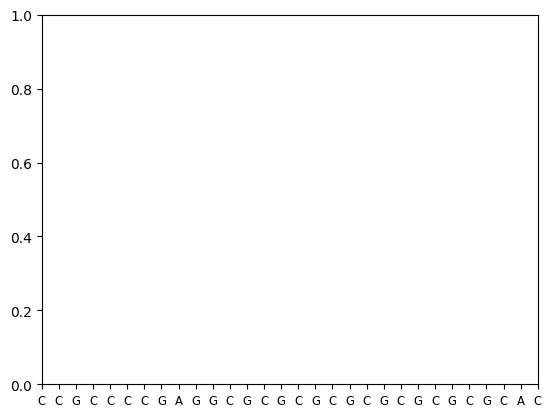

In [21]:
import pysam
seq = pysam.FastaFile(ref_genome_v1_0_gm_path).fetch('chr1',206586331, 206586361) #t2t v11: 206586162,206586192)
print(seq)
seq_list =  [s for s in seq]
plt.xticks(range(len(seq_list)), seq_list, size='small')

In [23]:
len(seq_list)

30

In [24]:
output_dir = "/content/drive/MyDrive/Michal Rozenwald/data/CTCF/dimelo_beta"

In [25]:
GM12878_deep_ctcf_bam_updated_cd55_ROI_30bps_path = Path("/content/drive/MyDrive/Michal Rozenwald/data/CTCF/deep_ctcf_mod_mappings_merge.sorted.updated.cd55_ROI_30bps.bam")
GM12878_deep_ctcf_bam_updated_cd55_ROI_30bps_path


PosixPath('/content/drive/MyDrive/Michal Rozenwald/data/CTCF/deep_ctcf_mod_mappings_merge.sorted.updated.cd55_ROI_30bps.bam')

In [26]:
GM12878_deep_ctcf_bam_updated_secondrun_cd55_ROI_30bps_path = Path("/content/drive/MyDrive/Michal Rozenwald/data/CTCF/deep_ctcf_mod_mappings_merge.sorted.updated.secondrun.cd55_ROI_30bps.bam")
GM12878_deep_ctcf_bam_updated_secondrun_cd55_ROI_30bps_path



PosixPath('/content/drive/MyDrive/Michal Rozenwald/data/CTCF/deep_ctcf_mod_mappings_merge.sorted.updated.secondrun.cd55_ROI_30bps.bam')

In [27]:
# GM12878_deep_ctcf_bam_updated_path = Path("/content/drive/MyDrive/Michal Rozenwald/data/CTCF/deep_ctcf_mod_mappings_merge.sorted.updated.bam")
# GM12878_deep_ctcf_bam_updated_path

PosixPath('/content/drive/MyDrive/Michal Rozenwald/data/CTCF/deep_ctcf_mod_mappings_merge.sorted.updated.bam')

In [30]:
GM12878_deep_ctcf_bam_updated_path = Path("/content/drive/MyDrive/Michal Rozenwald/data/CTCF/deep_ctcf_mod_mappings_merge.sorted.updated.secondrun.bam")
GM12878_deep_ctcf_bam_updated_path


PosixPath('/content/drive/MyDrive/Michal Rozenwald/data/CTCF/deep_ctcf_mod_mappings_merge.sorted.updated.secondrun.bam')

In [29]:
! ls "/content/drive/MyDrive/Michal Rozenwald/data/CTCF/GM12878_deepCTCF_T2Tv10_extract_30bps_chr1_206586331_206586361_thresh190_24Apr19"
# extract_file = "/content/drive/MyDrive/Michal Rozenwald/data/CTCF/GM12878_deepCTCF_T2Tv10_extract_30bps_chr1_206586331_206586361_thresh190_24Apr19/reads.combined_basemods.h5"

reads.combined_basemods.h5  regions.processed.bed


# parse_bam.extract

In [40]:
t2t_v1_0_cd55_30bp = "chr1:206586331-206586361"
# t2t_v1_0_cd55_30bp = "chr1:206586333-206586360" # "chr1:206586330-206586362" "chr1:206586332-206586360" "chr1:206586332-206586360"
# t2t_v1_0_cd55_30bp = "chr1:206586332-206586362" # "chr1:206586332-206586360""chr1:206586332-206586360"
# t2t_v1_0_cd55_30bp = "chr1:206586332-206586362" # "chr1:206586332-206586360""chr1:206586332-206586360"

extract_file, extract_regions = parse_bam.extract(
    input_file= GM12878_deep_ctcf_bam_updated_path, #  GM12878_deep_ctcf_bam_updated_secondrun_cd55_ROI_30bps_path, #GM12878_deep_ctcf_bam_updated_cd55_ROI_30bps_path, # GM12878_deep_ctcf_bam_updated_path, #  bam_cas9_12ef_101923_updated, # ctcf_bam_file_updated
    output_name="GM12878_deep_ctcf_bam_updated_24Apr22_extract_30bps_chr1_206586331_206586361_wsNone_thresh190", # 'cas9_12ef_101923_extract_30bps_chr1_206586162_206586192_wsNone_thresh190', # _ws4000 'ctcf_demo_extract',
    ref_genome=ref_genome_v1_0_gm_path, # ref_genome_v1_0_gm_path, # ref_genome_v1_1_file, # ref_genome_file,
    output_directory=output_dir,
    regions=t2t_v1_0_cd55_30bp, # [cd55_interest_target_regions], # ctcf_target_regions,ctcf_off_target_regions],
    motifs=['CG,0'], # ['A,0','CG,0'],
    thresh=None, # 190,
    window_size=None,
)


No specified number of cores requested. 2 available on machine, allocating all.
No valid base modification threshold provided. Raw probs will be saved.


          | Preprocessing   0% | 00:00

          | Processing deep_ctcf_mod_mappings_merge.sorted.updated.secondrun.bam   0% | 00:00<?

          |    0%

          | Transferring 30 from reads.CG,0.txt into reads.combined_basemods.h5, new size 30   0% | 00:00<?

In [41]:
read_data_list, datasets, _ = load_processed.read_vectors_from_hdf5(
    file=extract_file, # extract_file_no_thresh, # raw modification probabilities
    regions=t2t_v1_0_cd55_30bp, #t2t_cd55_30bps, # cd55_30bps_interest_coords, # ctcf_target_regions,
    motifs=['CG,0'], # 'A,0'],
    window_size=None,
)
print("len(read_data_list) = ", len(read_data_list))
# Print out the data from the first read
for idx,dataset in enumerate(datasets):
    print(dataset)
    for read_data in read_data_list:
        print('\t',read_data[idx])
        break

read_data_list, datasets, _

len(read_data_list) =  30
chromosome
	 chr1
mod_vector
	 [0.       0.       0.       ... 0.001953 0.       0.001953]
motif
	 CG,0
read_end
	 206588784
read_name
	 ce1ba6c4-db72-460b-988b-b7a1755c352a
read_start
	 206549618
strand
	 +
val_vector
	 [0. 0. 0. ... 1. 0. 1.]
region_start
	 206586331
region_end
	 206586361
CG,0_mod_fraction
	 0.001953


([('chr1',
   array([0.      , 0.      , 0.      , ..., 0.001953, 0.      , 0.001953],
         dtype=float16),
   'CG,0',
   206588784,
   'ce1ba6c4-db72-460b-988b-b7a1755c352a',
   206549618,
   '+',
   array([0., 0., 0., ..., 1., 0., 1.], dtype=float16),
   206586331,
   206586361,
   0.001953),
  ('chr1',
   array([0.      , 0.      , 0.      , ..., 0.001953, 0.      , 0.001953],
         dtype=float16),
   'CG,0',
   206590234,
   '1a6a0674-c098-4a22-b5cf-e980ab6bf037',
   206555114,
   '+',
   array([0., 0., 0., ..., 1., 0., 1.], dtype=float16),
   206586331,
   206586361,
   0.001953),
  ('chr1',
   array([0.      , 0.      , 0.      , ..., 0.001953, 0.      , 0.001953],
         dtype=float16),
   'CG,0',
   206612530,
   '8ae5a730-8b46-4667-ba90-18a87a016568',
   206559708,
   '+',
   array([0., 0., 0., ..., 1., 0., 1.], dtype=float16),
   206586331,
   206586361,
   0.001953),
  ('chr1',
   array([0.      , 0.      , 0.      , ..., 0.001953, 0.      , 0.001953],
         dtyp

In [42]:
len(read_data_list)

30

In [43]:
t2t_v1_0_cd55_30bp

'chr1:206586331-206586361'

<Axes: xlabel='pos', ylabel='read_name'>

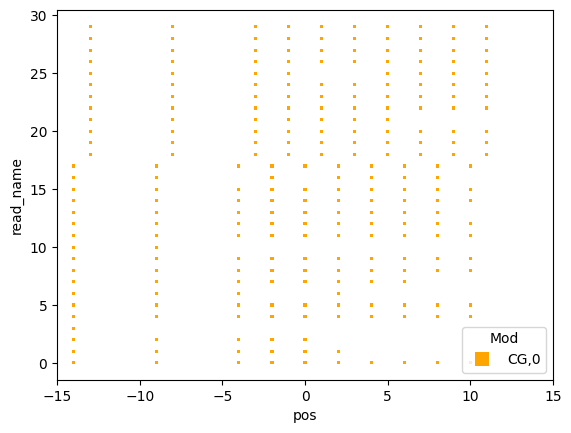

In [44]:
from matplotlib import pyplot as plt
from dimelo import plot_reads

plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = t2t_v1_0_cd55_30bp, # 'chr1:206586332-206586360',
    motifs = ['CG,0'],
    thresh = 0.00001, #0 None, # .75,
    sort_by = ['shuffle','strand'],
    relative = True, # False,
    window_size = None, # 5000,
    s=5,
)
# plt.xlim(206586331,206586361)
# plt.xlim(206582520,206585020)

# seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
# print(seq)
# seq_list =  [s for s in seq]
# plt.xticks(range(len(seq_list)), seq_list, size='small')

<Axes: xlabel='pos', ylabel='read_name'>

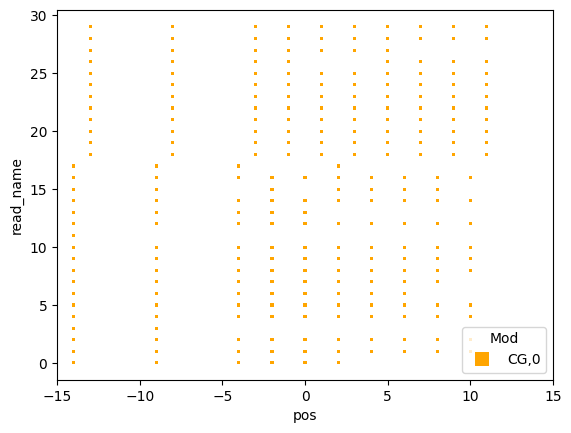

In [45]:
from matplotlib import pyplot as plt
from dimelo import plot_reads

plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = t2t_v1_0_cd55_30bp, # 'chr1:206586332-206586360',
    motifs = ['CG,0'],
    thresh = 0, # 0.00001, #0 None, # .75,
    sort_by = ['shuffle','strand'],
    relative = True, # False,
    window_size = None, # 5000,
    s=5,
)
# plt.xlim(206586331,206586361)
# plt.xlim(206582520,206585020)

# seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
# print(seq)
# seq_list =  [s for s in seq]
# plt.xticks(range(len(seq_list)), seq_list, size='small')

<Axes: xlabel='pos', ylabel='read_name'>

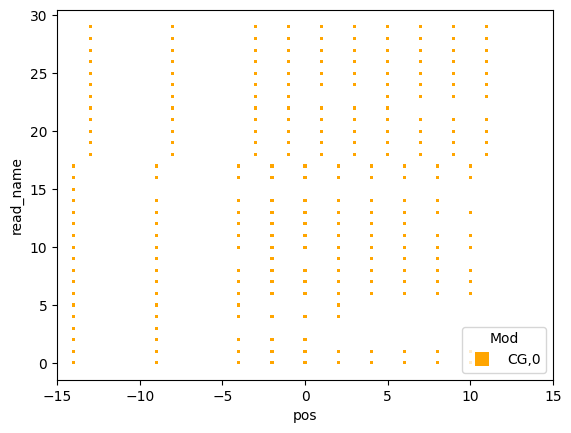

In [46]:
from matplotlib import pyplot as plt
from dimelo import plot_reads

plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = t2t_v1_0_cd55_30bp, # 'chr1:206586332-206586360',
    motifs = ['CG,0'],
    thresh = 0.001, #0 None, # .75,
    sort_by = ['strand'], # 'shuffle',
    relative = True, # False,
    window_size = None, # 5000,
    s=5,
)

<Axes: xlabel='pos', ylabel='read_name'>

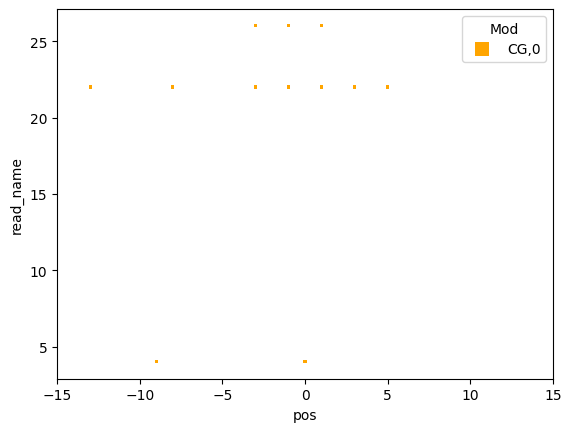

In [47]:
plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = t2t_v1_0_cd55_30bp, # 'chr1:206586332-206586360',
    motifs = ['CG,0'],
    thresh = 0.01, #0 None, # .75,
    sort_by = ['strand'], # 'shuffle',
    relative = True, # False,
    window_size = None, # 5000,
    s=5,
)

In [48]:
from pathlib import Path

import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes
import matplotlib.pyplot as plt

# from . import load_processed
# from . import utils

reads,read_names,mods,regions_dict = load_processed.readwise_binary_modification_arrays(
    extract_file, # extract_file_no_thresh, # raw modification probabilities
    regions=t2t_v1_0_cd55_30bp, # cd55_30bps_interest_coords, # ctcf_target_regions,
    motifs=['CG,0'], # 'A,0'],
    sort_by = ['strand'], # 'shuffle',
    window_size=None,
    thresh=0.001, # None,
)

# Convert data frame where each row represents a read to a data frame where each row represents a single modified position in a read
df = pd.DataFrame({
    'read_name': read_names,
    'mod': mods,
    'pos': reads
}).explode('pos')
df

,read_name,mod,pos
0,0,"CG,0",-14
1,0,"CG,0",-9
2,0,"CG,0",-4
3,0,"CG,0",-2
4,0,"CG,0",0
...,...,...,...
252,29,"CG,0",3
253,29,"CG,0",5
254,29,"CG,0",7
255,29,"CG,0",9


<Axes: xlabel='pos', ylabel='read_name'>

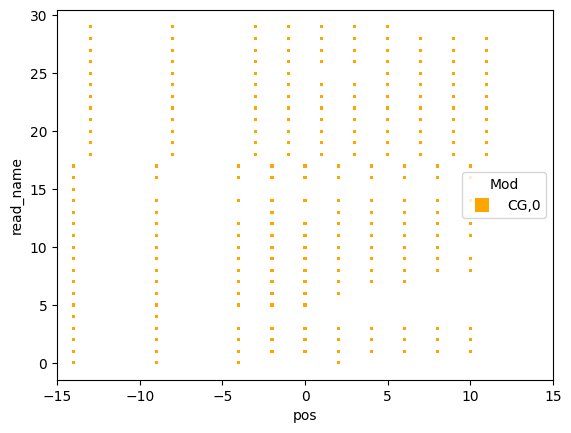

In [49]:
plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = t2t_v1_0_cd55_30bp, # 'chr1:206586332-206586360',
    motifs = ['CG,0'],
    thresh = 0.001, # None, #  0.1, #0.75,
    sort_by = ['shuffle','strand'],
    relative = True, # False,
    window_size = None, # 5000,
    s=5,
)

<Axes: xlabel='pos', ylabel='read_name'>

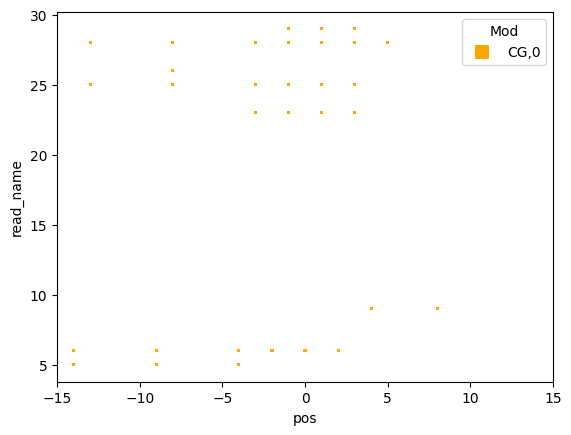

In [50]:
plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = t2t_v1_0_cd55_30bp, # 'chr1:206586332-206586360',
    motifs = ['CG,0'],
    thresh = 0.00196, #thresh = 0.001, # None, #  0.1, #0.75,
    sort_by = ['shuffle','strand'],
    relative = True, # False,
    window_size = None, # 5000,
    s=5,
)

In [51]:
# t2t_cd55_30bps used to be "chr1:206586162-206586192"

In [52]:
t2t_cd55_30bps = t2t_v1_0_cd55_30bp
t2t_cd55_30bps

'chr1:206586331-206586361'

In [53]:
206586332-206586362

-30

In [54]:
from pathlib import Path

import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes
import matplotlib.pyplot as plt

# from . import load_processed
# from . import utils

reads,read_names,mods,regions_dict = load_processed.readwise_binary_modification_arrays(
    extract_file, # extract_file_no_thresh, # raw modification probabilities
    regions=t2t_cd55_30bps, # cd55_30bps_interest_coords, # ctcf_target_regions,
    motifs=['CG,0'], # 'A,0'],
    sort_by = ['strand'], # 'shuffle',
    window_size=None,
    thresh = 0.001, # vs.  0.00196,
    relative = True, # False, #

)
      # file = mod_file_name,
      # regions = regions,
      # motifs = motifs,
      # window_size = window_size,
      # thresh = thresh,
      # relative = relative,
      # sort_by = sort_by,
    # )
  # match mod_file_name.suffix:
  #     case _:
  #         reads, read_names, mods = load_processed.reads_from_hdf5(
  #             file=mod_file_name,
#             bed_file=bed_file_name,
  #             mod_names=mod_names,
  #             window_size=window_size,
  #         )

# Convert data frame where each row represents a read to a data frame where each row represents a single modified position in a read
df = pd.DataFrame({
    'read_name': read_names,
    'mod': mods,
    'pos': reads
}).explode('pos')

In [55]:
df

,read_name,mod,pos
0,0,"CG,0",-14
1,0,"CG,0",-9
2,0,"CG,0",-4
3,0,"CG,0",-2
4,0,"CG,0",0
...,...,...,...
252,29,"CG,0",3
253,29,"CG,0",5
254,29,"CG,0",7
255,29,"CG,0",9


In [56]:
df

,read_name,mod,pos
0,0,"CG,0",-14
1,0,"CG,0",-9
2,0,"CG,0",-4
3,0,"CG,0",-2
4,0,"CG,0",0
...,...,...,...
252,29,"CG,0",3
253,29,"CG,0",5
254,29,"CG,0",7
255,29,"CG,0",9


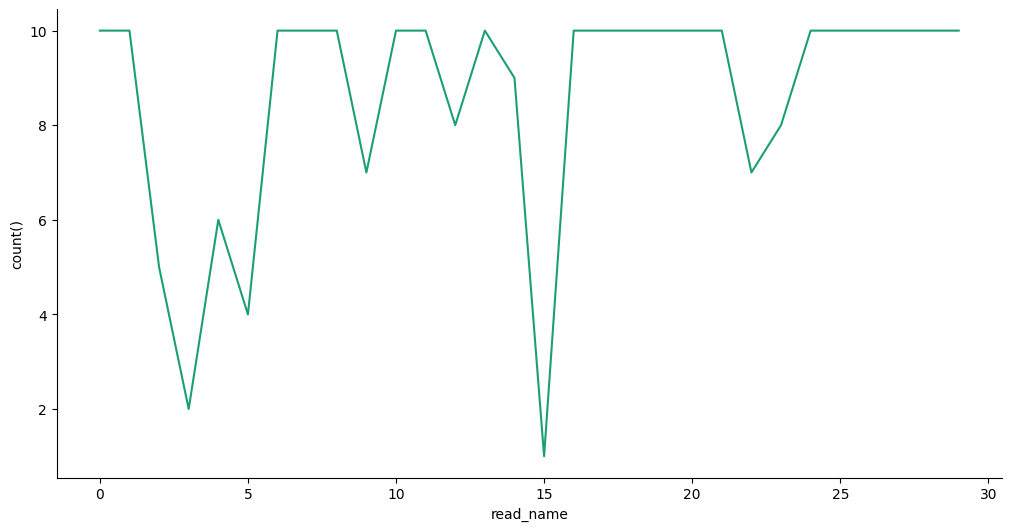

In [57]:
# @title read_name vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['read_name']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'read_name'}, axis=1)
              .sort_values('read_name', ascending=True))
  xs = counted['read_name']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('read_name', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('read_name')
_ = plt.ylabel('count()')

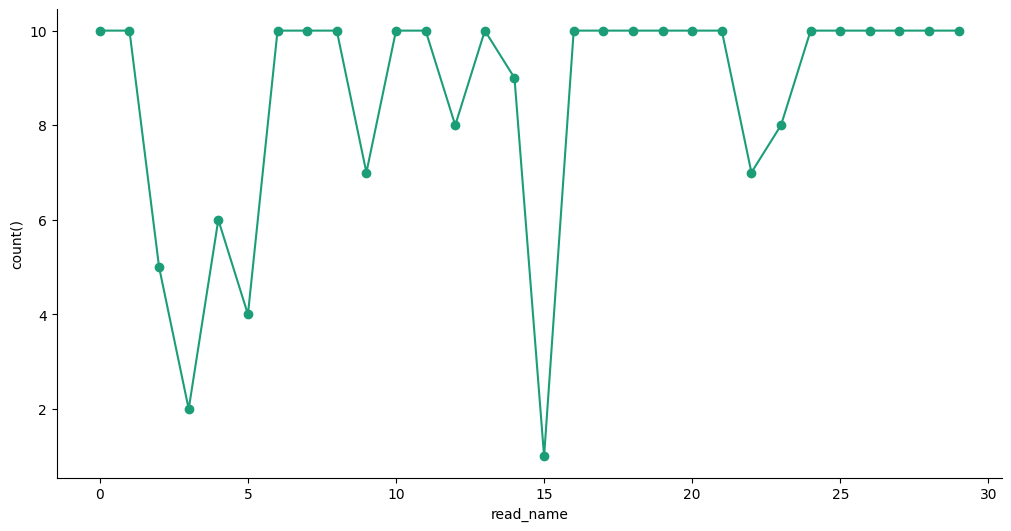

In [58]:
# @title read_name vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['read_name']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'read_name'}, axis=1)
              .sort_values('read_name', ascending=True))
  xs = counted['read_name']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)], marker='o' )

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('read_name', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('read_name')
_ = plt.ylabel('count()')

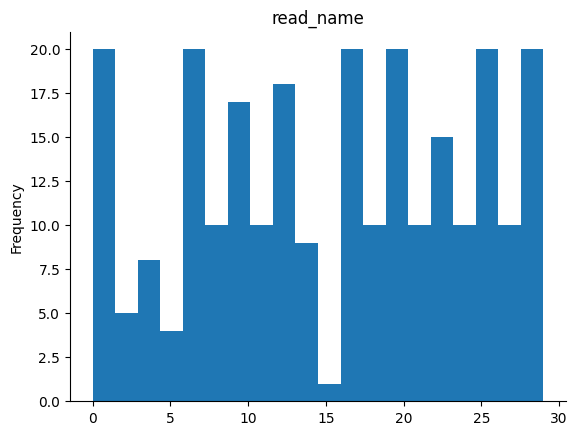

In [59]:
# @title read_name

from matplotlib import pyplot as plt
df['read_name'].plot(kind='hist', bins=20, title='read_name')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [60]:
import numpy as np
import pandas as pd

In [61]:
len(np.unique(df['read_name']))

30

In [62]:
all_reads = np.unique(df['read_name'])
all_reads

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [63]:
df['pos_shifted'] = df['pos'] + 15
df

,read_name,mod,pos,pos_shifted
0,0,"CG,0",-14,1
1,0,"CG,0",-9,6
2,0,"CG,0",-4,11
3,0,"CG,0",-2,13
4,0,"CG,0",0,15
...,...,...,...,...
252,29,"CG,0",3,18
253,29,"CG,0",5,20
254,29,"CG,0",7,22
255,29,"CG,0",9,24


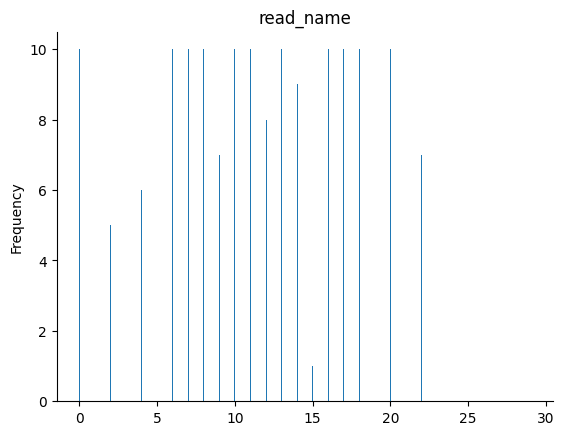

In [64]:
# @title read_name

from matplotlib import pyplot as plt
df['read_name'].plot(kind='hist', bins=800, title='read_name')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [65]:
len(np.unique(df.read_name))

30

# Qs: <!> 766 not 920 -> why?

In [66]:
df[df["read_name"] == 0]

,read_name,mod,pos,pos_shifted
0,0,"CG,0",-14,1
1,0,"CG,0",-9,6
2,0,"CG,0",-4,11
3,0,"CG,0",-2,13
4,0,"CG,0",0,15
5,0,"CG,0",2,17
6,0,"CG,0",4,19
7,0,"CG,0",6,21
8,0,"CG,0",8,23
9,0,"CG,0",10,25


In [67]:

df[df["read_name"] == 16]

,read_name,mod,pos,pos_shifted
122,16,"CG,0",-14,1
123,16,"CG,0",-9,6
124,16,"CG,0",-4,11
125,16,"CG,0",-2,13
126,16,"CG,0",0,15
127,16,"CG,0",2,17
128,16,"CG,0",4,19
129,16,"CG,0",6,21
130,16,"CG,0",8,23
131,16,"CG,0",10,25


In [70]:
df[df["read_name"] == 1] #160]

,read_name,mod,pos,pos_shifted
10,1,"CG,0",-14,1
11,1,"CG,0",-9,6
12,1,"CG,0",-4,11
13,1,"CG,0",-2,13
14,1,"CG,0",0,15
15,1,"CG,0",2,17
16,1,"CG,0",4,19
17,1,"CG,0",6,21
18,1,"CG,0",8,23
19,1,"CG,0",10,25


# > empty values for other positions?
> fill in the empy values?

In [193]:
# df.groupby(['read_name']['pos']).mean()

In [71]:
(df.groupby(['read_name'])).head()#.mean()

,read_name,mod,pos,pos_shifted
0,0,"CG,0",-14,1
1,0,"CG,0",-9,6
2,0,"CG,0",-4,11
3,0,"CG,0",-2,13
4,0,"CG,0",0,15
...,...,...,...,...
247,29,"CG,0",-13,2
248,29,"CG,0",-8,7
249,29,"CG,0",-3,12
250,29,"CG,0",-1,14


In [72]:
df

,read_name,mod,pos,pos_shifted
0,0,"CG,0",-14,1
1,0,"CG,0",-9,6
2,0,"CG,0",-4,11
3,0,"CG,0",-2,13
4,0,"CG,0",0,15
...,...,...,...,...
252,29,"CG,0",3,18
253,29,"CG,0",5,20
254,29,"CG,0",7,22
255,29,"CG,0",9,24


<ipython-input-73-1436c324b5ac>:29: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


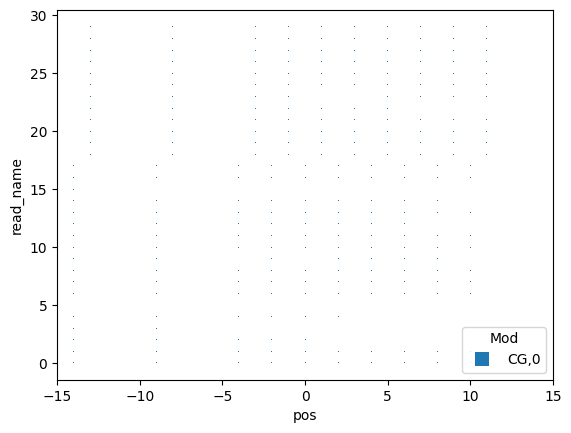

In [73]:
# Link to function https://github.com/streetslab/dimelo/blob/modkit_parsing_beta/dimelo/plot_reads.py#L56C1-L79C22

# mod_file_name = Path(mod_file_name)
# bed_file_name = Path(bed_file_name)
size = 0.5 # kwargs.pop('s', 0.5)

# palette = kwargs.pop('palette', {})

# merged_palette = {**utils.DEFAULT_COLORS, **palette}

axes = sns.scatterplot(
    data=df,
    x="pos",
    y="read_name",
    hue="mod",
    # palette=colors,
    s=size,
    marker="s",
    linewidth=0,
    # palette = merged_palette,
    # **kwargs
)
# Retrieve the existing legend
legend = axes.legend_

# Update legend properties
if legend is not None:
    legend.set_title('Mod')
    for handle in legend.legendHandles:
        handle.set_markersize(10)  # Set a larger marker size for legend

relative = True
if relative:
    region1_start,region1_end,_ = next(iter(regions_dict.values()))[0]
    effective_window_size = (region1_end-region1_start)//2
    axes.set_xlim([-effective_window_size,effective_window_size])

# return axes

In [74]:
extract_file

PosixPath('/content/drive/MyDrive/Michal Rozenwald/data/CTCF/dimelo_beta/GM12878_deep_ctcf_bam_updated_24Apr22_extract_30bps_chr1_206586331_206586361_wsNone_thresh190/reads.combined_basemods.h5')

In [75]:
extract_file

PosixPath('/content/drive/MyDrive/Michal Rozenwald/data/CTCF/dimelo_beta/GM12878_deep_ctcf_bam_updated_24Apr22_extract_30bps_chr1_206586331_206586361_wsNone_thresh190/reads.combined_basemods.h5')

In [86]:

reads,read_names,mods,regions_dict = load_processed.readwise_binary_modification_arrays(
    extract_file, # extract_file_no_thresh, # raw modification probabilities
    regions=t2t_cd55_30bps, # cd55_30bps_interest_coords, # ctcf_target_regions,
    motifs=['CG,0'], # 'A,0'],
    relative = False,
    thresh=0.001,
    # window_size = None, # window_size,
)
      # file = mod_file_name,
      # regions = regions,
      # motifs = motifs,
      # window_size = window_size,
      # thresh = thresh,
      # relative = relative,
      # sort_by = sort_by,
  # )
  # match mod_file_name.suffix:
  #     case _:
  #         reads, read_names, mods = load_processed.reads_from_hdf5(
  #             file=mod_file_name,
#             bed_file=bed_file_name,
  #             mod_names=mod_names,
  #             window_size=window_size,
  #         )

# Convert data frame where each row represents a read to a data frame where each row represents a single modified position in a read
df_with_coords = pd.DataFrame({
    'read_name': read_names,
    'mod': mods,
    'pos': reads
}).explode('pos')

In [87]:
len(np.unique(df_with_coords.read_name))

30

In [88]:
df_with_coords

,read_name,mod,pos
0,0,"CG,0",206586332
1,0,"CG,0",206586337
2,0,"CG,0",206586342
3,0,"CG,0",206586344
4,0,"CG,0",206586346
...,...,...,...
252,29,"CG,0",206586348
253,29,"CG,0",206586350
254,29,"CG,0",206586352
255,29,"CG,0",206586354


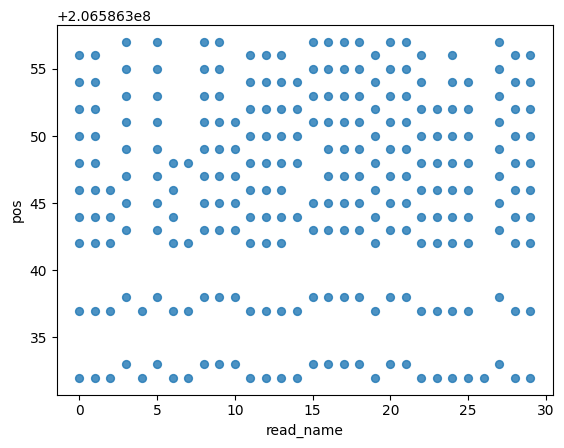

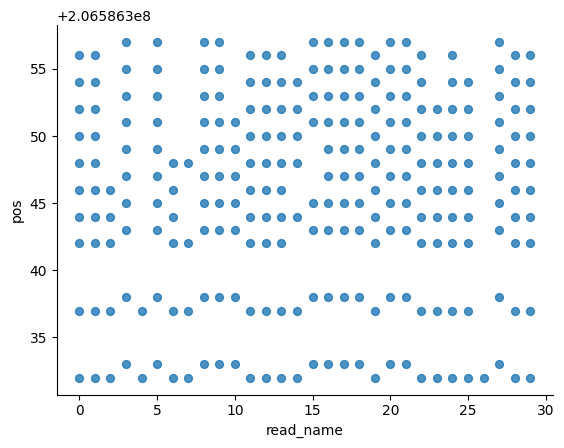

In [89]:
# @title read_name vs pos

from matplotlib import pyplot as plt
df_with_coords.plot(kind='scatter', x='read_name', y='pos', s=32, alpha=.8)
df_with_coords.plot(kind='scatter', x='read_name', y='pos', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

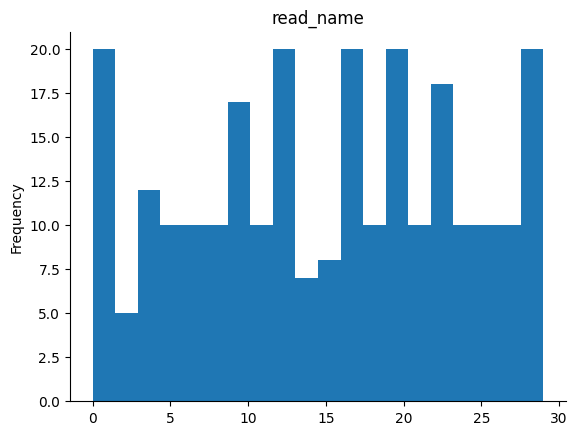

In [90]:
# @title read_name

from matplotlib import pyplot as plt
df_with_coords['read_name'].plot(kind='hist', bins=20, title='read_name')
plt.gca().spines[['top', 'right',]].set_visible(False)

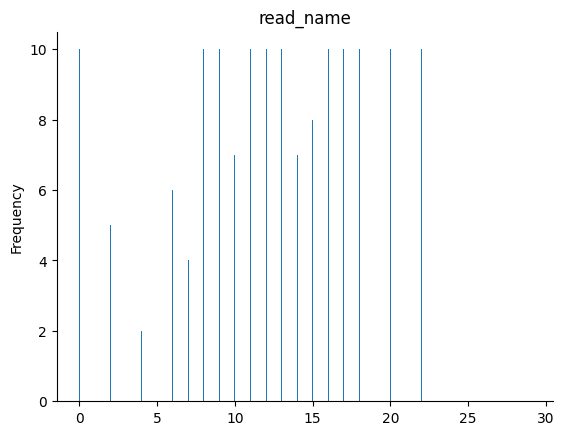

In [91]:
# @title read_name

from matplotlib import pyplot as plt
df_with_coords['read_name'].plot(kind='hist', bins=800, title='read_name')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Extract the mC vectors for each read




In [92]:
df

,read_name,mod,pos,pos_shifted
0,0,"CG,0",-14,1
1,0,"CG,0",-9,6
2,0,"CG,0",-4,11
3,0,"CG,0",-2,13
4,0,"CG,0",0,15
...,...,...,...,...
252,29,"CG,0",3,18
253,29,"CG,0",5,20
254,29,"CG,0",7,22
255,29,"CG,0",9,24


In [93]:
df['read_name']

0       0
1       0
2       0
3       0
4       0
       ..
252    29
253    29
254    29
255    29
256    29
Name: read_name, Length: 257, dtype: int64

In [94]:
# for df
df

,read_name,mod,pos,pos_shifted
0,0,"CG,0",-14,1
1,0,"CG,0",-9,6
2,0,"CG,0",-4,11
3,0,"CG,0",-2,13
4,0,"CG,0",0,15
...,...,...,...,...
252,29,"CG,0",3,18
253,29,"CG,0",5,20
254,29,"CG,0",7,22
255,29,"CG,0",9,24


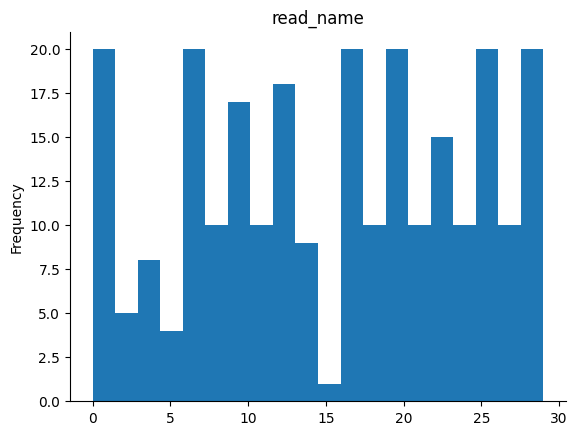

In [95]:
# @title read_name

from matplotlib import pyplot as plt
df['read_name'].plot(kind='hist', bins=20, title='read_name')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [96]:
df.groupby("read_name").count() #["pos"].count()

,mod,pos,pos_shifted
read_name,,,
0,10,10,10
1,10,10,10
2,5,5,5
3,2,2,2
4,6,6,6
5,4,4,4
6,10,10,10
7,10,10,10
8,10,10,10


In [97]:
len(read_names)

257

In [98]:
read_names_unique = np.unique(df['read_name'])
num_reads = len(read_names_unique)
num_reads

30

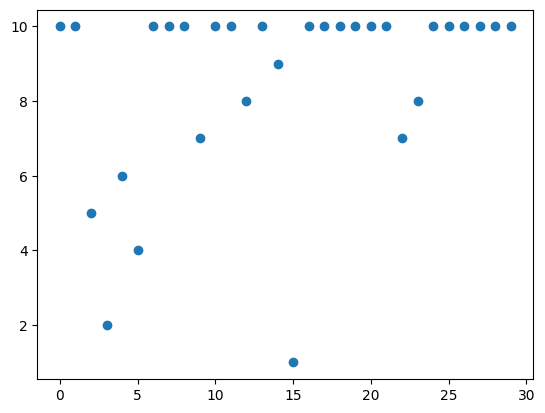

In [99]:
plt.scatter(read_names_unique, df.groupby("read_name")["pos"].count()) #)

(array([ 1.,  1.,  0.,  1.,  1.,  1.,  2.,  2.,  1., 20.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

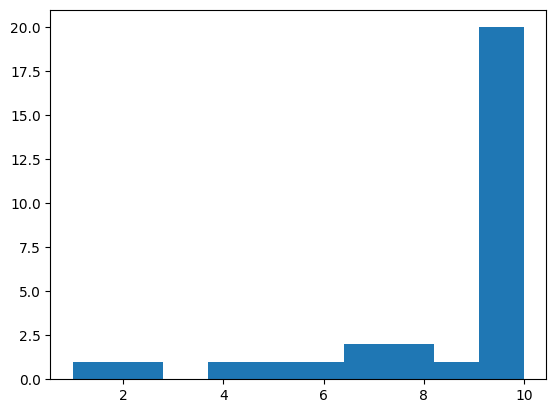

In [100]:
plt.hist(df.groupby("read_name")["pos"].count()) #)

In [101]:
seq

'CCGCCCCGAGGCGCGCGCGCGCGCGCGCAC'

In [102]:
len(seq.split("CG"))

11

In [103]:
num_reads

30

In [104]:
reads_dict_nums = dict(enumerate(read_names_unique))
reads_dict_nums

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29}

In [105]:
reads_dict = dict()

for i in range(len(read_names_unique)):
  reads_dict[read_names_unique[i]] = i
reads_dict

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29}

# <!!!!> Build padded reads <!!!!>

In [106]:
padded_reads = np.zeros([num_reads, 30])
padded_reads

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0

In [107]:
padded_reads.shape

(30, 30)

# SWITCH TO Nans -> to distriguish empty values from unmethylated

In [108]:
padded_reads = padded_reads + np.nan
padded_reads.shape, padded_reads

((30, 30),
 array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, n

In [109]:
i=16
df['read_name'][i]#, df['pos_shifted'][i]]

1

In [110]:
i=1
padded_reads[reads_dict[df['read_name'][i]], df['pos_shifted'][i]]

nan

In [111]:
for i in range(len(df['read_name'])):
  # df['pos_shifted']:
  padded_reads[reads_dict[df['read_name'][i]], df['pos_shifted'][i]] = 1
padded_reads

array([[nan,  1., nan, nan, nan, nan,  1., nan, nan, nan, nan,  1., nan,
         1., nan,  1., nan,  1., nan,  1., nan,  1., nan,  1., nan,  1.,
        nan, nan, nan, nan],
       [nan,  1., nan, nan, nan, nan,  1., nan, nan, nan, nan,  1., nan,
         1., nan,  1., nan,  1., nan,  1., nan,  1., nan,  1., nan,  1.,
        nan, nan, nan, nan],
       [nan,  1., nan, nan, nan, nan,  1., nan, nan, nan, nan,  1., nan,
         1., nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan,  1., nan, nan, nan, nan,  1., nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan,  1., nan, nan, nan, nan,  1., nan, nan, nan, nan,  1., nan,
         1., nan,  1., nan,  1., nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan,  1., nan, nan, nan, nan,  1., nan, nan, nan, nan,  1., nan,
        nan, nan, nan, nan,  1., nan, nan, nan, nan,

In [112]:
padded_reads[0]

array([nan,  1., nan, nan, nan, nan,  1., nan, nan, nan, nan,  1., nan,
        1., nan,  1., nan,  1., nan,  1., nan,  1., nan,  1., nan,  1.,
       nan, nan, nan, nan])

In [113]:
df[df["read_name"] == 0]

,read_name,mod,pos,pos_shifted
0,0,"CG,0",-14,1
1,0,"CG,0",-9,6
2,0,"CG,0",-4,11
3,0,"CG,0",-2,13
4,0,"CG,0",0,15
5,0,"CG,0",2,17
6,0,"CG,0",4,19
7,0,"CG,0",6,21
8,0,"CG,0",8,23
9,0,"CG,0",10,25


In [114]:
padded_reads

array([[nan,  1., nan, nan, nan, nan,  1., nan, nan, nan, nan,  1., nan,
         1., nan,  1., nan,  1., nan,  1., nan,  1., nan,  1., nan,  1.,
        nan, nan, nan, nan],
       [nan,  1., nan, nan, nan, nan,  1., nan, nan, nan, nan,  1., nan,
         1., nan,  1., nan,  1., nan,  1., nan,  1., nan,  1., nan,  1.,
        nan, nan, nan, nan],
       [nan,  1., nan, nan, nan, nan,  1., nan, nan, nan, nan,  1., nan,
         1., nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan,  1., nan, nan, nan, nan,  1., nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan,  1., nan, nan, nan, nan,  1., nan, nan, nan, nan,  1., nan,
         1., nan,  1., nan,  1., nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan],
       [nan,  1., nan, nan, nan, nan,  1., nan, nan, nan, nan,  1., nan,
        nan, nan, nan, nan,  1., nan, nan, nan, nan,

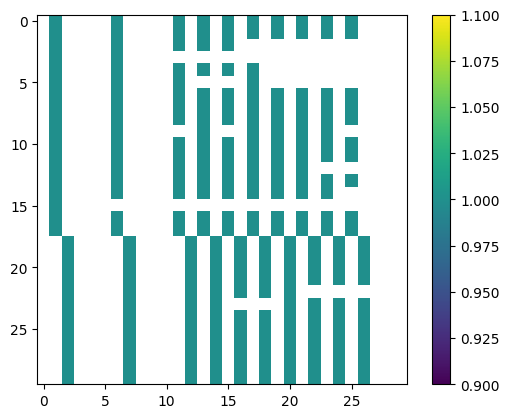

In [115]:
plt.imshow(padded_reads) # np.random.random((50,50)))
plt.colorbar()
plt.show()

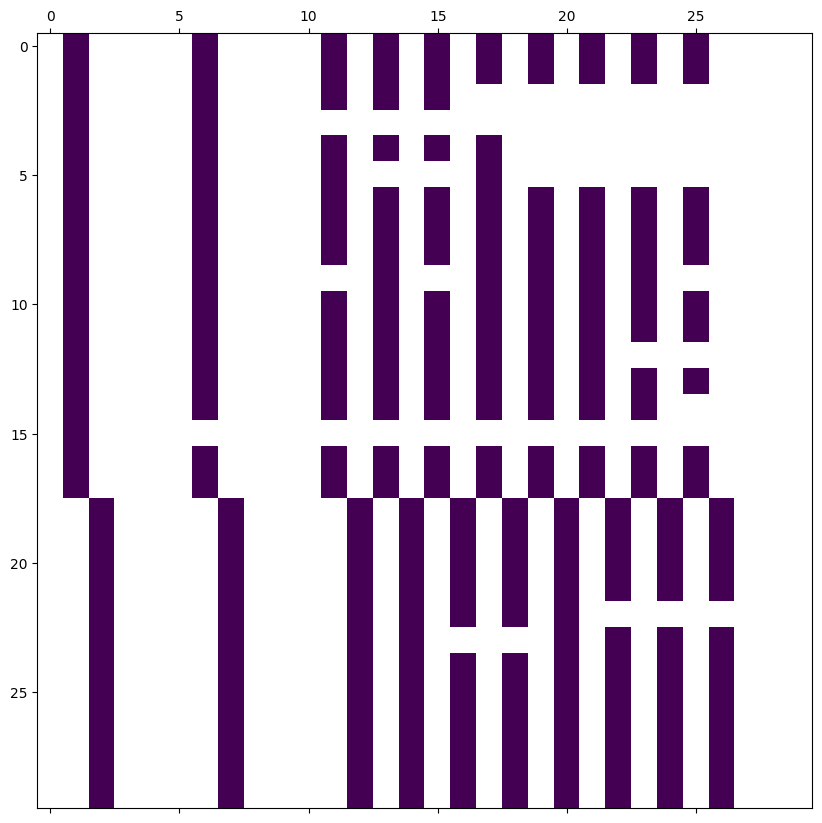

In [116]:
plt.figure(figsize=(10,50))
plt.matshow(padded_reads, fignum=1)


In [117]:
padded_reads_df = pd.DataFrame(padded_reads)
padded_reads_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
1,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
2,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
7,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
8,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
9,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
len(seq_list), seq_list

(30,
 ['C',
  'C',
  'G',
  'C',
  'C',
  'C',
  'C',
  'G',
  'A',
  'G',
  'G',
  'C',
  'G',
  'C',
  'G',
  'C',
  'G',
  'C',
  'G',
  'C',
  'G',
  'C',
  'G',
  'C',
  'G',
  'C',
  'G',
  'C',
  'A',
  'C'])

In [119]:
padded_reads_df.columns = seq_list
padded_reads_df

,C,C,G,C,C,C,C,G,A,G,...,G,C,G,C,G,C,G,C,A,C
0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
1,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
2,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
7,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
8,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
9,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
padded_reads_df.describe()

,C,C,G,C,C,C,C,G,A,G,...,G,C,G,C,G,C,G,C,A,C
count,0.0,18.0,12.0,0.0,0.0,0.0,17.0,12.0,0.0,0.0,...,12.0,13.0,11.0,12.0,11.0,10.0,11.0,0.0,0.0,0.0
mean,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
std,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
min,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
25%,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
50%,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
75%,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
max,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN


# Save mC profiles np.ARRAY!

In [121]:
padded_reads.shape, padded_reads

((30, 30),
 array([[nan,  1., nan, nan, nan, nan,  1., nan, nan, nan, nan,  1., nan,
          1., nan,  1., nan,  1., nan,  1., nan,  1., nan,  1., nan,  1.,
         nan, nan, nan, nan],
        [nan,  1., nan, nan, nan, nan,  1., nan, nan, nan, nan,  1., nan,
          1., nan,  1., nan,  1., nan,  1., nan,  1., nan,  1., nan,  1.,
         nan, nan, nan, nan],
        [nan,  1., nan, nan, nan, nan,  1., nan, nan, nan, nan,  1., nan,
          1., nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan,  1., nan, nan, nan, nan,  1., nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan,  1., nan, nan, nan, nan,  1., nan, nan, nan, nan,  1., nan,
          1., nan,  1., nan,  1., nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan,  1., nan, nan, nan, nan,  1., nan, nan, nan, nan,  1., nan,
         nan, nan, nan, n

In [122]:
!pwd

/content/dimelo


In [127]:
save_folder_path = "/content/drive/MyDrive/Michal Rozenwald/data/CD55/dimelo/etracted_reads"
save_folder_path

'/content/drive/MyDrive/Michal Rozenwald/data/CD55/dimelo/etracted_reads'

In [124]:
# cd55_30pbRIO_padded_reads_24Apr16.npy
save_name_np = "deepCTCF_thresh0_001_cd55_30pbRIO_padded_reads_24Apr23.npy"
Path(save_folder_path, save_name_np)

PosixPath('/content/drive/MyDrive/Michal Rozenwald/data/CD55/dimelo/etracted_reads/deepCTCF_thresh0_001_cd55_30pbRIO_padded_reads_24Apr23.npy')

In [125]:
# cd55_30pbRIO_padded_reads_24Apr16.npy
save_name = "deepCTCF_thresh0_001_cd55_30pbRIO_padded_reads_24Apr23"
save_name_np = save_name + ".npy"

np.save(Path(save_folder_path, save_name_np), padded_reads)

In [126]:
# # save_name = "cd55_30pbRIO_padded_reads_24Apr16"
# save_name_csv = save_name + ".csv"

# padded_reads_df.to_csv(Path(save_folder_path, save_name_csv))

# TODO: [2024, Apr. 16]:
- repeat this mC arrays extraction for our other .bam files - start with GM12878 - deepest - 30 bps - deepCTCF that I have stored theoretically xD

- count how many compliteley empty reads at the whole ROI 30bps region (maybe they had some signal outside out ROI - which is why they passes the QC filters?)


- have a way to differenciate the lack of signal within the read and "outside" - meanin before/after the read beginning/end
- -  =>>> maybe store the start - end coords of a read - of at least if it's cutting inside my ROI?
- - add "-1" for the emply values that are "between" the first and last mC signal for each read? (this will alow me to avoid going back to extracting the full coordinates -> which is less clean and more short term, but at least identifies that the empty signal is INSIDE the actually sequenced READ???)

# Looking at the Cas9 nanopore data T2T

In [36]:
t2t_v1_1_cd55_30bp = 'chr1:206586162-206586192'
t2t_v1_1_cd55_30bp

'chr1:206586162-206586192'

In [37]:
bam_cas9_12ef_101923_updated = "/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/mc_only/cas9_12ef_101923_misha_mod_mappings.sorted_mC_only.updated.bam"
output_dir = Path('/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package') # './test/output')

output_dir.mkdir(exist_ok=True)
output_dir

PosixPath('/content/drive/MyDrive/Michal Rozenwald/data/CD55/cas9_12ef_101923_misha/dimelo_new_package')

In [38]:
206586162-206586192

-30

# Download & Use the T2T v.1.1 -> for my Cas9 runs

In [40]:
# ! mkdir ./test/output/
!wget https://s3-us-west-2.amazonaws.com/human-pangenomics/T2T/CHM13/assemblies/chm13.draft_v1.1.fasta.gz -O ./test/output/chm13.draft_v1.1.fasta.gz
!gunzip ./test/output/chm13.draft_v1.1.fasta.gz

--2024-04-22 23:48:53--  https://s3-us-west-2.amazonaws.com/human-pangenomics/T2T/CHM13/assemblies/chm13.draft_v1.1.fasta.gz
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.246.240, 52.92.229.0, 52.218.170.8, ...
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.246.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 892637258 (851M) [binary/octet-stream]
Saving to: ‘./test/output/chm13.draft_v1.1.fasta.gz’

./test/output/chm13 100%[===================>] 851.29M  29.5MB/s    in 26s     

2024-04-22 23:49:19 (32.5 MB/s) - ‘./test/output/chm13.draft_v1.1.fasta.gz’ saved [892637258/892637258]



In [41]:
!pwd

/content/dimelo


In [42]:
from pathlib import Path
ref_genome_v1_1_file = Path('./test/output/chm13.draft_v1.1.fasta')
ref_genome_v1_1_file

PosixPath('test/output/chm13.draft_v1.1.fasta')

# parse_bam.extract

In [43]:
# t2t_cd55_30bps = 'chr1:206586162-206586192'
t2t_v1_1_cd55_30bp = 'chr1:206586162-206586192'
t2t_v1_1_cd55_30bp

extract_file, extract_regions = parse_bam.extract(
    input_file=bam_cas9_12ef_101923_updated, # ctcf_bam_file_updated
    output_name='cas9_12ef_101923_extract_30bps_chr1_206586162_206586192_wsNone_thresh190_repeat', # _ws4000 'ctcf_demo_extract',
    ref_genome=ref_genome_v1_1_file, # ref_genome_file,
    output_directory=output_dir,
    regions=t2t_v1_1_cd55_30bp, # t2t_cd55_30bps, # [cd55_interest_target_regions], # ctcf_target_regions,ctcf_off_target_regions],
    motifs=['CG,0'], # ['A,0','CG,0'],
    thresh=190,
    window_size=None,

    # cores = 1, # uncomment this line if your process appears to be terminating early (reduces memory usage)
    # quiet = True,
    # cleanup = False,
    # log=True,
)

Indexing chm13.draft_v1.1.fasta. This only needs to be done once.
No specified number of cores requested. 2 available on machine, allocating all.
Modification threshold of 190 assumed to be for range 0-255. 190/255=0.7450980392156863 will be sent to modkit.


          | Preprocessing   0% | 00:00

          | Processing cas9_12ef_101923_misha_mod_mappings.sorted_mC_only.updated.bam   0% | 00:00<?

          |    0%

          | Transferring 920 from reads.CG,0.txt into reads.combined_basemods.h5, new size 920   0% | 00:00<?

In [44]:
read_data_list, datasets, _ = load_processed.read_vectors_from_hdf5(
    file=extract_file, # extract_file_no_thresh, # raw modification probabilities
    regions=t2t_v1_1_cd55_30bp, #t2t_cd55_30bps, # cd55_30bps_interest_coords, # ctcf_target_regions,
    motifs=['CG,0'], # 'A,0'],
    window_size=None,
)
# Print out the data from the first read
for idx,dataset in enumerate(datasets):
    print(dataset)
    for read_data in read_data_list:
        print('\t',read_data[idx])
        break

chromosome
	 chr1
mod_vector
	 [False False False ... False False  True]
motif
	 CG,0
read_end
	 206590113
read_name
	 9343e1fe-dfbc-4434-b969-95a0ee2bd0f2
read_start
	 206583052
strand
	 +
val_vector
	 [False False False ...  True False  True]
region_start
	 206586162
region_end
	 206586192
CG,0_mod_fraction
	 0.5


In [46]:
# reads, read_names, mods, regions_dict
read_data_list, datasets, _

([('chr1',
   array([False, False, False, ..., False, False,  True]),
   'CG,0',
   206590113,
   '9343e1fe-dfbc-4434-b969-95a0ee2bd0f2',
   206583052,
   '+',
   array([False, False, False, ...,  True, False,  True]),
   206586162,
   206586192,
   0.5),
  ('chr1',
   array([False, False, False, ..., False, False, False]),
   'CG,0',
   206589926,
   'b69854bc-ff64-4b07-bf2e-b05edf6385ba',
   206583052,
   '+',
   array([False, False, False, ...,  True, False,  True]),
   206586162,
   206586192,
   0.1),
  ('chr1',
   array([False, False, False, ..., False, False, False]),
   'CG,0',
   206589931,
   '4a9708df-dfb6-4e6f-8795-a6f3e697e947',
   206583052,
   '+',
   array([False, False, False, ...,  True, False,  True]),
   206586162,
   206586192,
   0.3),
  ('chr1',
   array([False, False, False, ..., False, False, False]),
   'CG,0',
   206589933,
   '51a762b4-5376-49f0-8d2d-32fe9a21236f',
   206583052,
   '+',
   array([False, False, False, ..., False, False,  True]),
   206586162,

<Axes: xlabel='pos', ylabel='read_name'>

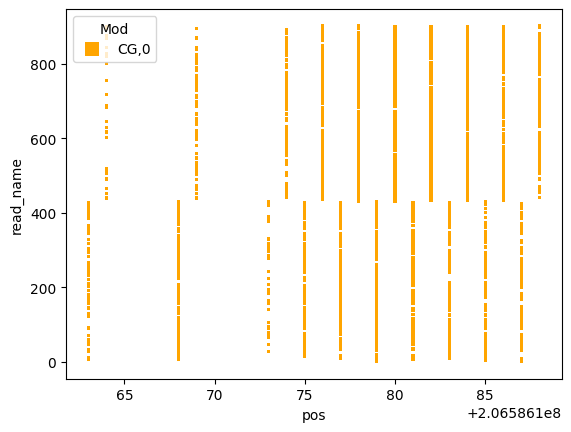

In [57]:
from matplotlib import pyplot as plt
from dimelo import plot_reads

plot_reads.plot_reads(
    extract_file, # extracted_h5,
    regions = 'chr1:206582520-206585020',
    motifs = ['CG,0'],
    thresh = 0.75,
    sort_by = ['shuffle','strand'],
    relative = False,
    window_size = None, # 5000,
    s=5,
)
# plt.xlim(206582520,206585020)


# seq = pysam.FastaFile(ref_genome_v1_1_file).fetch('chr1',206586162,206586192)
# print(seq)
# seq_list =  [s for s in seq]
# plt.xticks(range(len(seq_list)), seq_list, size='small')